# Histogram Equalization

In [1]:
%matplotlib inline 

from scipy import ndimage
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import math

Here's the image we'll be equalizing. Notice the lower light near the bottom and the higher light near the top.

(674, 500, 3)


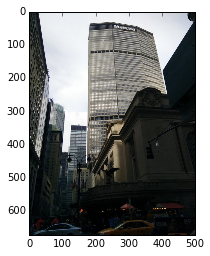

In [2]:
f = ndimage.imread("ny.jpg")
plt.imshow(f)

dims = f.shape
print dims

Here's just the R channel

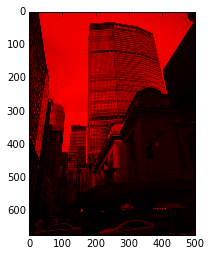

In [3]:
g = np.ndarray.copy(f)
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if(k == 0):
                g[i,j,k] = f[i,j,k]
            else:
                g[i,j,k] = 0
                
plt.imshow(g)

## Standard Histogram Equalization
Here's the histogram for the R channel

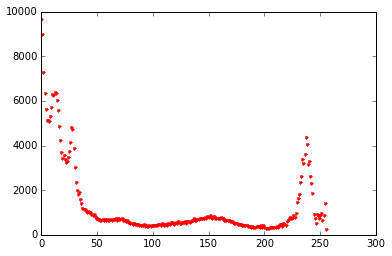

In [4]:
channels = []
for i in range(3):
    channels.append(f[:,:,i])

hist = map(lambda channel: ndimage.measurements.histogram(channel, 0, 255, 256), channels)

plt.plot(hist[0], 'r.')

Here's the CDF (integral of histogram)

note the discrete points in the high slope runs

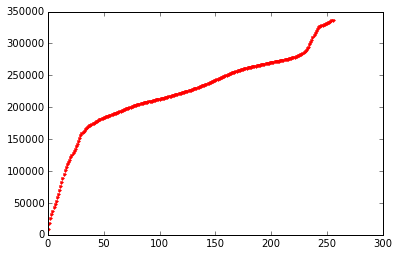

In [5]:
cum = map(lambda h: [], hist)
sums = map(lambda h: 0, hist)
for i in range(256):
    for j in range(3):
        sums[j] += hist[j][i]
        cum[j].append(sums[j])

plt.plot(cum[0], 'r.')      

Here's the scaled CDF.

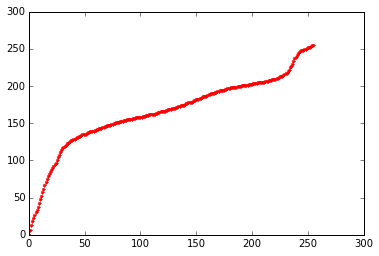

In [6]:
#array must be sorted
def scale(arr, rmin, rmax):
    dmax = float(arr[-1])
    dmin = float(arr[0])
    
    drange = dmax-dmin
    rrange = rmax-rmin
    
    shifted_down = map(lambda x: float(x) - dmin, arr)
    scaled_up = map(lambda f: f * rrange, shifted_down)
    scaled_down = map(lambda f: f / drange, scaled_up)
    shifted_up = map(lambda f: f + rmin, scaled_down)
    ints = map(lambda f: int(round(f)), shifted_up)
    
    return ints

cum = map(lambda cumi: scale(cumi, 0., 255.), cum)
plt.plot(cum[0], 'r.')

And finally, here's the equalized R channel

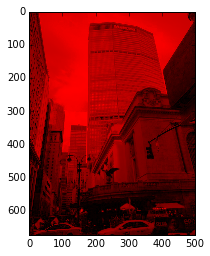

In [7]:
g = np.ndarray.copy(f)
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if(k == 0):
                g[i,j,k] = cum[k][g[i,j,k]]
            else:
                g[i,j,k] = 0

plt.imshow(g)

And here's the equalized picture

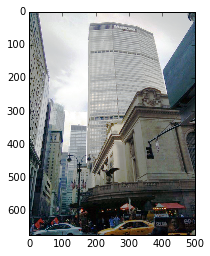

In [8]:
g = np.ndarray.copy(f)
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
                g[i,j,k] = cum[k][g[i,j,k]]

plt.imshow(g)

The histogram for the equalized picture looks wierd. A lot of color values don't occur, even though every color value for red occurred in the original image. This is because discrete inputs are unable to cover the full continuouts space. See my essay for more.

[9667    0    0    0    0    0    0 8996    0    0    0    0    0 7299    0
    0    0    0 6345    0    0    0 5643    0    0    0 5165    0    0    0
 5161    0    0    0 5100    0    0    0 5321    0    0    0    0 5745    0
    0    0    0 6318    0    0    0 6285    0    0    0    0 6417    0    0
    0    0 6340    0    0    0    0 6034    0    0    0 5585    0    0    0
 4891    0    0    0 4250    0    0 3731    0 3454    0    0 3556    0    0
 3377    0 3262    0    0 3316    0 3502    0    0 3744    0    0    0 4136
    0    0 4819    0    0    0 4756    0    0 3911    0 3040    0 2363    0
 1992 1815    0 1909 1599 1403 1180 1167 1163 2107 1086 1019 1027 1826  926
 1593 1478  694 1329 1343 1396 1352 1410 1384  727 1463 1420 1424 1399 1352
 1313 1162 1055 1489 1435  888 1327 1263 1680  887 1289 1357 1445 1416 1046
 1134 1576 1105 1112 1724 1184 1155 1201 1300 1396 1353  726 1462 1505 1521
  787 1577  814 1662 1556  863 1521 1476  741 1557 1439 1314 1300 1202 1167
 1574  954 1

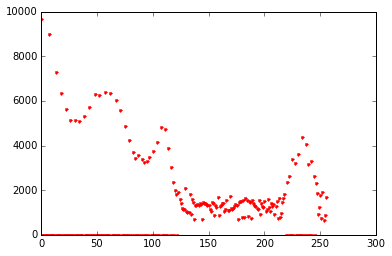

In [9]:
nchannels = []
for i in range(3):
    nchannels.append(g[:,:,i])

nhist = map(lambda channel: ndimage.measurements.histogram(channel, 0, 255, 256), nchannels)

print nhist[0]
plt.plot(nhist[0], 'r.')

And finally, note that histogram equalization worked, since the CDF of our equalized image is a line.

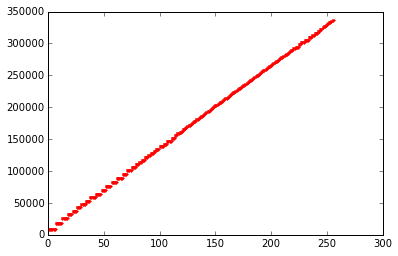

In [10]:
ncum = map(lambda h: [], nhist)
nsums = map(lambda h: 0, nhist)
for i in range(256):
    for j in range(3):
        nsums[j] += nhist[j][i]
        ncum[j].append(nsums[j])

plt.plot(ncum[0], 'r.')        
# ncum = map(lambda cumi: scale(cumi, 0., 255.), ncum)

## Locally Adaptive Histogram Equalization

* <span style="color: red">TODO: name variables so that the code is readable</span>

* wrap histogram generation into function
* call on block sections of image (corner gets 4 blocks)
* use grid of histograms to generate new image

In [11]:
def cdf(hists):
    '''converts a set of histograms (for various color channels) to a set of CDFs'''
    cum = map(lambda h: [], hists)
    sums = map(lambda h: 0, hists)
    for i in range(256):
        for j in range(3):
            sums[j] += hists[j][i]
            cum[j].append(sums[j])

    cum = map(lambda cumi: scale(cumi, 0., 255.), cum)
    return cum

def equalize(image):
    '''performs global histogram equalization on an image'''
    channels = []
    for i in range(3):
        channels.append(image[...,i])
    
    hist = map(lambda channel: ndimage.measurements.histogram(channel, 0, 255, 256), channels)
    cdfs = cdf(hist)
    
    equalized = np.ndarray.copy(image)
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                    equalized[i,j,k] = cdfs[k][equalized[i,j,k]]
        
    return equalized

* __hists__ is a set of 3 histograms, one per channel
* __cum__, which is returned, is a set of 3 lookup tables, one per channel

let's test it out!

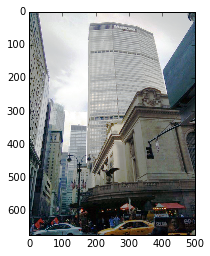

In [12]:
plt.imshow(equalize(g))

Let's setup some basic parameters

In [13]:
window_size = 300

num_cols = int( math.ceil( float(f.shape[0])/window_size ) )
num_rows = int( math.ceil( float(f.shape[1])/window_size ) )

histograms = np.empty( (num_cols, num_rows, 3, 256) )
h_shape = histograms.shape

cdfs = np.empty(histograms.shape)

# channels = []
# for i in range(3):
#     channels.append(f[:,:,i])

* __m__ is the window size
* __histograms__ is a set of histograms, one for each window corner
* __channels__ is a channel-wise breakdown of the image

In [14]:
#assuming that i, j is within a block of k, l
def w(i, j, k, l, m):
    '''returns the bilinear weight of (i,j) in terms of corner (k,l) with window size m'''
    i = float(i)
    j = float(j)
    k = float(k)
    l = float(l)
    m = float(m)
    #s and t are distances from the top left corner
    s = (i-k)/m if k <= i else (i - (k-m))/m
    t = (j-l)/m if l <= j else (j - (l-m))/m
    weight = 1
    
    weight *= (1-s) if k <= i else (s)
    weight *= (1-t) if l <= j else (t)
    return weight

Now, let's test out the bilinear weighting function

In [15]:
print w(0.1, 0.2, 0, 0, 1)
print w(0.1, 0.2, 0, 1, 1)
print w(0.1, 0.2, 1, 0, 1)
print w(0.1, 0.2, 1, 1, 1)

0.72
0.18
0.08
0.02


Nice! all the corners' weights add up to 1!

In [16]:
def slice(img_channel, corner_x, corner_y, m):
    '''returns a slice of img_channel corresponding to pixels within one window
    of the corner with indexes (corner_x, corner_y), along with bilinear weights.
    
    a corner (1, 1) would have k and l values (1*m, 1*m)'''
    minx = max((corner_x-1)*m, 0)
    miny = max((corner_y-1)*m, 0)
    maxx = min((corner_x+1)*m, img_channel.shape[0])
    maxy = min((corner_y+1)*m, img_channel.shape[1])
    
    s = img_channel[minx:maxx,miny:maxy]
    weights = np.empty((maxx-minx, maxy-miny))
    for i in range(maxx-minx):
        for j in range(maxy-miny):
            weights[i,j] = w(i+minx, j+miny,
                             corner_x*m, corner_y*m, 
                             m) #bilinear weighting function
    
    return s, weights

def hist_slice(img_channel, corner_x, corner_y, window_size):
    '''returns a weighted histogram for img_channel containing pixels within one window of (corner_x, corner_y)'''
    s, weights = slice(img_channel, corner_x, corner_y, window_size)
    return np.histogram(s, bins=256, range=(0,255), weights=weights)

let's test it out!

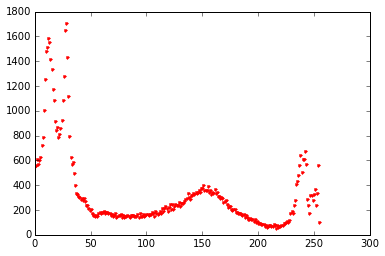

In [17]:
plt.plot(hist_slice(f[...,0], 1, 1, window_size)[0], 'r.')

now, let's calculate histograms for each block corner

In [18]:
print h_shape

for i in range(h_shape[0]):
    for j in range(h_shape[1]):
        histograms[i,j] = np.array(map(lambda channel: hist_slice(channel, i, j, window_size)[0], channels))


(3, 2, 3, 256)


try plotting any corner histogram you'd like!

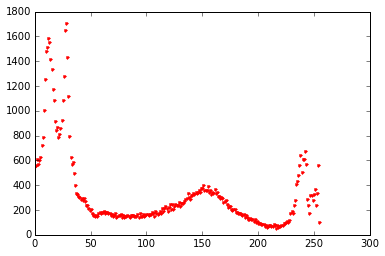

In [19]:
plt.plot(histograms[1,1,0], 'r.')

let's make some CDFs from these histograms!

In [20]:
for i in range(h_shape[0]):
    for j in range(h_shape[1]):
        cdfs[i,j] = cdf(histograms[i,j].tolist())

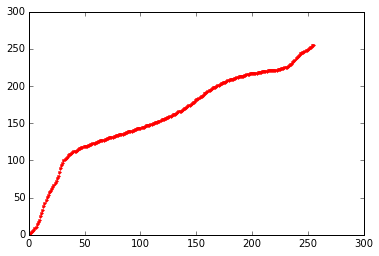

In [21]:
plt.plot(cdfs[1,1,0], 'r.')

To equalize, we just add up corners according to the bilinear weighting function

we add them up according to the bilinear weighting function because they're all scaled from 0 to 255

In [22]:
def bilinear_weighted(img, cdfs, i, j, m, channel):
    k = i/m
    l = j/m
    color_value = img[i,j]
    
    #s and t are distances from the top left corner
    s = float(i-(k*m))/float(m)
    t = float(j-(l*m))/float(m)
    
    if(s < 0 or t < 0 or s > 1 or t > 1):
        print "ERR"
    
    #change weights based on edge cases
    if(k+1 >= cdfs.shape[0]):
        s = 0.
    if(l+1 >= cdfs.shape[1]):
        t = 0.
    
    sum =  (1-s)*(1-t)*cdfs[k,l,channel,color_value]
    if(k+1 < cdfs.shape[0]): #handle edge cases
        sum += (s)  *(1-t)*cdfs[k+1,l,channel,color_value]
    if(l+1 < cdfs.shape[1]):
        sum += (1-s)*(t)  *cdfs[k,l+1,channel,color_value]
    if(k+1 < cdfs.shape[0] and l+1 < cdfs.shape[1]):
        sum += (s)  *(t)  *cdfs[k+1,l+1,channel,color_value]
    
    return int(sum)

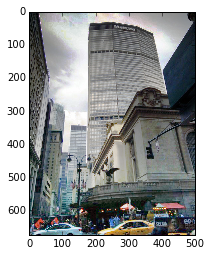

In [23]:
adaptively_equalized = np.ndarray.copy(f)

for i in range(dims[0]):
    for j in range(dims[1]):
        for channel in range(dims[2]):
            adaptively_equalized[i, j, channel] = bilinear_weighted(f[...,channel], cdfs, i, j, window_size, channel)
            
plt.imshow(adaptively_equalized)

Some notes on implementation:

* I had to raise m to soemthing like 300, because if the windowing is too small, it produces a really wierd effect which doesn't really consider broad swaths of the image. 
* at some point, I'll package this entire adaptive thing into one nice funciton to try with different m values

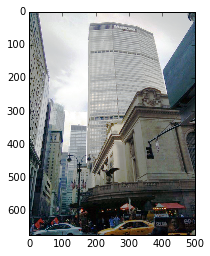

In [24]:
plt.imshow(g)

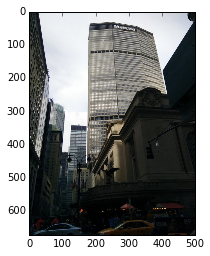

In [25]:
plt.imshow(f)

Let's package the adaptive histogram algorithm into one function, so we can play with window size.

In [28]:
def adaptive_equalize(image, window_size):
    num_cols = int( math.ceil( float(f.shape[0])/window_size ) )
    num_rows = int( math.ceil( float(f.shape[1])/window_size ) )

    histograms = np.empty( (num_cols, num_rows, 3, 256) )
    h_shape = histograms.shape
    dims = image.shape

    cdfs = np.empty(histograms.shape)
    
    channels = []
    for i in range(3):
        channels.append(image[...,i])
    
    for i in range(h_shape[0]):
        for j in range(h_shape[1]):
            histograms[i,j] = np.array(map(lambda channel: hist_slice(channel, i, j, window_size)[0], channels))
    
    for i in range(h_shape[0]):
        for j in range(h_shape[1]):
            cdfs[i,j] = cdf(histograms[i,j].tolist())
    
    adaptively_equalized = np.ndarray.copy(image)

    for i in range(dims[0]):
        for j in range(dims[1]):
            for channel in range(dims[2]):
                adaptively_equalized[i, j, channel] = bilinear_weighted(image[...,channel], cdfs, i, j, window_size, channel)
    return adaptively_equalized
    

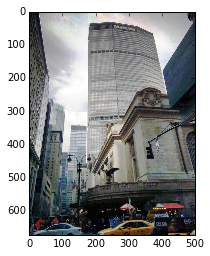

In [35]:
plt.imshow(adaptive_equalize(f, 400))

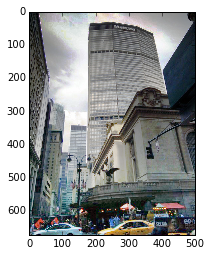

In [36]:
plt.imshow(adaptive_equalize(f, 300))

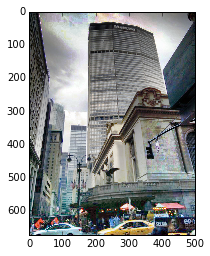

In [34]:
plt.imshow(adaptive_equalize(f, 200))

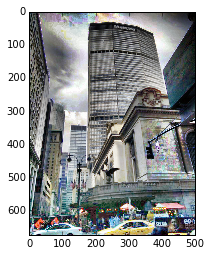

In [33]:
plt.imshow(adaptive_equalize(f, 100))

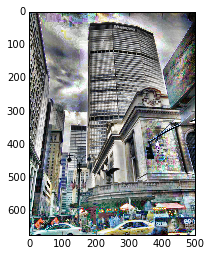

In [32]:
plt.imshow(adaptive_equalize(f, 50))